In [1]:
### In this tutorial, we demonstrate how to run the A3D3a's MVP model pipeline, including the following steps:
# 1. Find first neighbors for the input seed genes
# 2. Build disease network and run MVP model for prioritizing the key vulnerabilities
# 3. Run the community detection of the disease network, in each community run the MVP model individually
# 4. Plot the top ranked genes of each community
# 5. Perform enrichment analysis for identifying hallmark pathways in each community

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
# TCGA_BRCA_DNA_altered_freq.csv 
# can be downloaded from https://github.com/YingZ-A3D3a/A3D3a_MVP/blob/main/input/TCGA_BRCA_DNA_altered_freq.csv

In [2]:
### build graph from input seed genes
from adaMVP import mvp_build_graph as mbg
output_path = './adaMVP_results'
os.makedirs(output_path,exist_ok = True)

mbg.find_fn_and_pgm(save_directory = output_path,
            to_remove = ['TTN','MUC16'],
            altered_freq_file = 'TCGA_BRCA_DNA_altered_freq.csv',
            fn_num = 550,
            thre = 0.05,
            Wm = 0.5,
            alpha = 0.1,
            n_perm = 10000)

Interactome loaded!
seed list size: 101
Start permutation test for finding first neighbors:


100%|█████████████████████████████████████████| 10000/10000 [03:14<00:00, 51.43it/s]


---------------------------------------------
fn:550,Wm:0.5,alpha:0.1
model:Markov, network size: 639, completed!


In [3]:
from adaMVP import adj_mat_interactome as ami  # adjacency matrix of the background interactome
from adaMVP import graph_builder as gb  # largest connected graph

In [4]:
gm = ami.adj_mat() # adjacency matrix of the background interactome

Interactome loaded!


In [5]:
gm.shape

(18614, 18614)

In [6]:
gm.head()

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
A1BG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2ML1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A3GALT2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
### load adaMVP output gene rank file
files = os.listdir(output_path)
prefix = 'markov_output'
match_files = [filename for filename in files if filename.startswith(prefix)]
fnm = os.path.join(output_path,match_files[0])
final_prob_markov = pd.read_csv(fnm)
final_prob_markov.index = final_prob_markov.genes
final_prob_markov.head()

,genes,final_score,initial_score,degree_in_disease,degree_in_background,degree_in_disease_normalized,publications,final_rank,source
genes,,,,,,,,,
TP53,TP53,0.073817,0.251451,0.470219,0.068658,6.84872,11045.0,1,seed
PIK3CA,PIK3CA,0.041743,0.258221,0.205329,0.023638,8.68636,1628.0,2,seed
MYC,MYC,0.032777,0.155706,0.394984,0.064682,6.10651,2476.0,3,seed
CCND1,CCND1,0.019652,0.155706,0.169279,0.013807,12.26054,1722.0,4,seed
CDH1,CDH1,0.013832,0.093810,0.263323,0.041098,6.40718,2130.0,5,seed


In [8]:
# community detection
import networkx.algorithms.community as nx_comm
import random

disease_genes = final_prob_markov.genes.values.tolist()
g_adj = gb.seed_network(disease_genes,gm)
g = gb.build_graph(g_adj)
random_seed = 12345
comms = nx_comm.louvain_communities(g, resolution = 0.7, seed=random_seed)
# sorting on basis of size of list
comms.sort(key = lambda x:len(x), reverse = True)

In [9]:
def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}
    
def plot_the_top_ranked_genes_in_community(df,comm_id,save_dir,top_k=30,
                                           edge_width = 0.8,line_width = 0.08,
                                           green = '#03AC13',
                                           blue = '#0030BF',
                                           yellow = '#CC7722',
                                           node_size = 10,fig_size = [5, 4.6]):
    final_prob_markov = df.copy()
    genes_top = final_prob_markov.genes[:top_k].values.tolist()
    size_comm = final_prob_markov.shape[0]
    g_adj = gb.seed_network(genes_top,gm)
    g = gb.build_graph(g_adj)
    
    nodes_1 = []
    nodes_2 = []

    node_colorcode = []

    for k in g.nodes:
        if final_prob_markov.loc[final_prob_markov.genes==k,'source'].values[0]!='first neighbor':   # seed
            nodes_1.append(k)
        elif final_prob_markov.loc[final_prob_markov.genes==k,'source'].values[0]=='first neighbor':   # first neighbors
            nodes_2.append(k)

    plt.rcParams['figure.figsize'] = fig_size
    plt.rcParams['svg.fonttype'] = 'none'
    fig, ax = plt.subplots()
    # pos = nx.spring_layout(g, seed = 500, k = 0.95)
    pos = nx.kamada_kawai_layout(g)
    # size
    slope = 0
    intercept = 5

    # node facecolor
    max_cr = top_k
    cr1 = [(final_prob_markov.loc[final_prob_markov.genes==k,'final_rank'].values[0]) for k in nodes_1]
    cr2 = [(final_prob_markov.loc[final_prob_markov.genes==k,'final_rank'].values[0]) for k in nodes_2]

    vmin, vmax = 1, max_cr
    cmap = 'Wistia_r'

    nx.draw_networkx_nodes(g,pos,nodelist=nodes_1,edgecolors='k',linewidths=edge_width,node_color = cr1,node_shape='o',node_size=node_size,cmap = cmap,vmin=vmin,vmax=vmax) # WES/SV
    nx.draw_networkx_nodes(g,pos,nodelist=nodes_2,edgecolors='k',linewidths=edge_width,node_color = cr2,node_shape='s',node_size=node_size,cmap = cmap,vmin=vmin,vmax=vmax) # first neighbor
    
    pos_nodes = nudge(pos, 0, 0.05)
    nx.draw_networkx_edges(g,pos,width=.1,edge_color='#BBBBBB',alpha = 0.6)
    labels = nx.draw_networkx_labels(g,pos_nodes,font_color = 'k', font_weight = 'normal', font_size = 5,font_family = 'Arial')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, ticks=np.arange(10, vmax, 10), orientation='vertical', aspect=5, fraction=0.04, pad=0.03, label='rank of genes')
    tick_font_size = 5
    cbar.ax.tick_params(labelsize=tick_font_size)
    cbar.set_label(label='rank of genes',size=5)
    plt.title('Community '+str(comm_id),fontsize = 5)
    print(f'Top {top_k} genes in the community were plotted.')
    fnm = os.path.join(save_dir,f'Top {top_k} in community {comm_id} disease network with genes.png')
    plt.savefig(fnm,dpi = 300, bbox_inches='tight')
    plt.show()

community 1, size=245
model:Markov, network size: 245, completed!
Top 30 genes in the community were plotted.


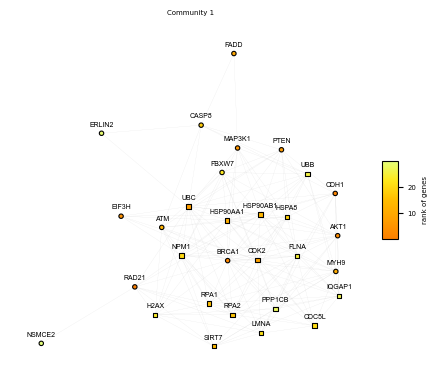

community 2, size=243
model:Markov, network size: 243, completed!
Top 30 genes in the community were plotted.


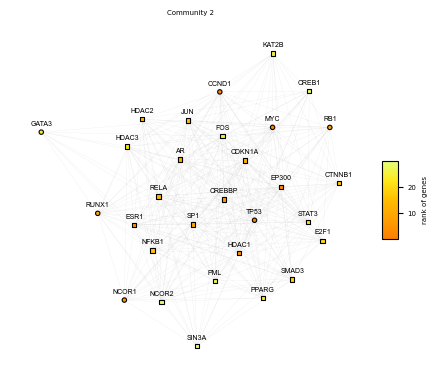

community 3, size=147
model:Markov, network size: 147, completed!
Top 30 genes in the community were plotted.


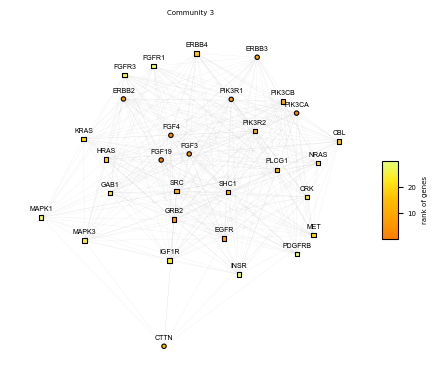

community 4, size=4
model:Markov, network size: 4, completed!
Top 30 genes in the community were plotted.


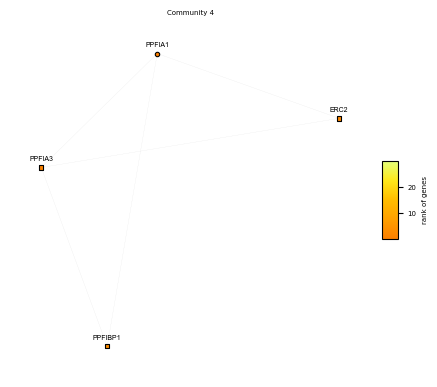

In [10]:
# run adaMVP model on each individual community
import networkx as nx
from adaMVP import graphical_models as gms
from adaMVP import markov_model_dataframe as mmd

for i in range(len(comms)):
    print(f"community {i+1}, size={len(comms[i])}")
    comm = comms[i]
    genex = list(comm)[0]
    
    ### run graphical model on a community
    score_ini = {}
    for item in comm:
        score_ini[item] = final_prob_markov.loc[final_prob_markov.genes==item,'initial_score'].values[0]
    final_prob_markov0 = gms.run_pipeline_unequal(gm,genex,comm,score_ini,alpha = 0.1,Wm = 0.5,modelx='Markov')
    
    s_list = comm
    final_prob_markov_sub = mmd.info_markov(final_prob_markov0,s_list,gm)
    
    final_prob_markov_sub['source'] = final_prob_markov.loc[final_prob_markov_sub.genes,'source'].values.tolist()
    comm_id = i+1
    plot_the_top_ranked_genes_in_community(final_prob_markov_sub,comm_id,save_dir = output_path)

In [ ]:
# gseapy can be installed by "pip install gseapy"

In [11]:
import gseapy

In [12]:
enri_mat = pd.DataFrame() 
for i in range(len(comms)):
    print(f"community {i+1}, size={len(comms[i])}")
    comm = comms[i]
    Hallmark_depmap = gseapy.enrichr(gene_list=list(comm),
         gene_sets=['MSigDB_Hallmark_2020'],
         organism='Human',
         cutoff=0.05)
    tmp = Hallmark_depmap.res2d
    tmp['community'] = [i+1 for k in range(tmp.shape[0])]
    enri_mat = pd.concat([enri_mat,tmp],axis = 0)

community 1, size=245
community 2, size=243
community 3, size=147
community 4, size=4


In [13]:
enri_mat.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,community
0,MSigDB_Hallmark_2020,E2F Targets,19/200,5.855977e-12,2.693749e-10,0,0,9.091722,235.144295,H2AX;CBX5;MCM7;EED;TUBB;CSE1L;RPA1;RPA2;NAP1L1...,1.0
1,MSigDB_Hallmark_2020,G2-M Checkpoint,14/200,1.852029e-07,4.259666e-06,0,0,6.376344,98.844900,H2AX;HSPA8;RPA2;FANCC;BRCA2;TPX2;WRN;DBF4;RAD2...,1.0
2,MSigDB_Hallmark_2020,Apoptosis,12/161,7.251886e-07,1.111956e-05,0,0,6.776853,95.803244,CASP9;DNAJA1;CASP7;CASP8;CASP3;CDK2;LMNA;CASP1...,1.0
3,MSigDB_Hallmark_2020,Apical Junction,12/200,6.995366e-06,6.435737e-05,0,0,5.360332,63.628553,ACTA1;CDH3;JUP;ARPC2;CDH1;AKT3;CTNNA1;PTEN;SYM...,1.0
4,MSigDB_Hallmark_2020,Myc Targets V1,12/200,6.995366e-06,6.435737e-05,0,0,5.360332,63.628553,CCT3;CCT2;LDHA;NPM1;HSP90AB1;MCM7;CBX3;RPS6;CD...,1.0


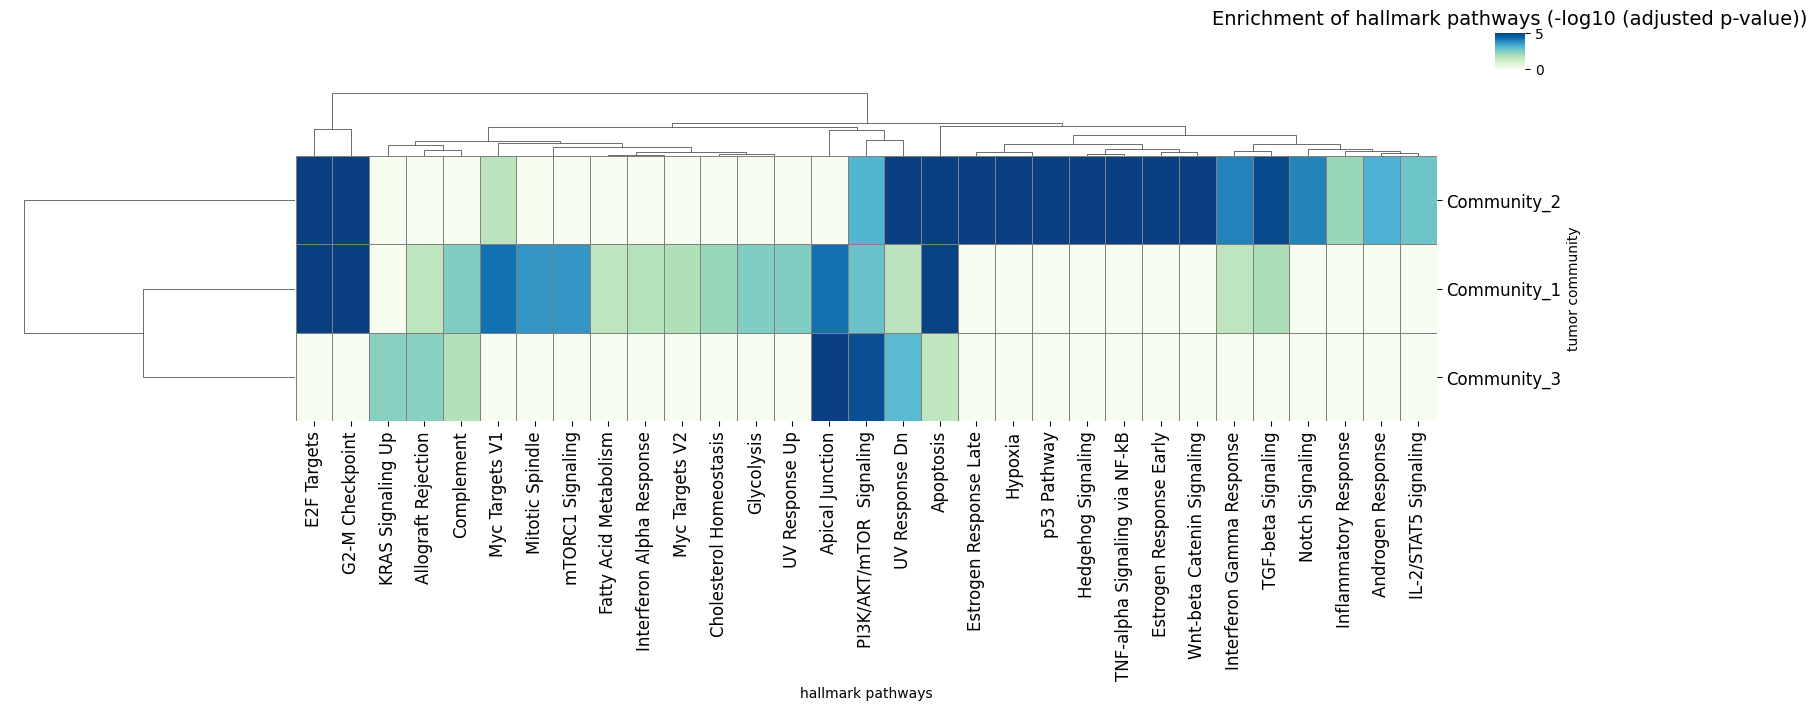

In [21]:
### make clustermap
hallmarks = enri_mat.loc[(enri_mat['Adjusted P-value']<0.05),].copy()
hallmarks['Community'] = 'Community_'+hallmarks['community'].astype(int).astype(str)
hallmarks['-log10(adjusted p-value)'] = -np.log10(hallmarks['Adjusted P-value'].values.astype('float'))
h_df = hallmarks.pivot(index = 'Community',columns = 'Term',values = '-log10(adjusted p-value)')
h_df = h_df.fillna(0)

plt.rcParams["figure.figsize"] = (18,20)
g = sns.clustermap(h_df,cmap = 'GnBu',xticklabels=True, yticklabels=True, cbar_pos=(1, 1.01, .02, .06),
                   cbar_kws={'shrink': 0.1},linewidth = 0.5,linecolor = 'gray',vmin=0, vmax=5,
                figsize=(15,(2*(len(h_df.index)))))
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 12, rotation = 90)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 12, rotation = 0)
g.ax_heatmap.set(xlabel='hallmark pathways', ylabel='tumor community')
title = f'Enrichment of hallmark pathways (-log10 (adjusted p-value))'
plt.title(title, fontsize = 14)
fnm = os.path.join(output_path,'hallmark pathways enriched each community clustermap.png')
plt.savefig(fnm,dpi = 256, bbox_inches='tight')
plt.show()